# COVID-19 "study" with epidemiology models (WIP)

* **READ HERE FIRST: This is not an official study! This is very unlike to represent real scenarios! I'm not specialist in Epidemiology! This is a very simple demonstration about how to handle the models!**

* **READ EVEN MORE: Real studies and predictions should be performed by teams with multiple specialities. COVID-19 is a real thing, don't propagate results and data as conclusive if YOU ARE NOT A SPECIALIST IN THE FIELD.**

## Table of Contents

1. [Importing libs](#importing)

2. [Loading data](#loading)

3. [Data cleaning](#cleaning)

4. [(Very) Basic EDA](#eda)

5. [Epidemiology models](#models)

6. [Programming SIR/SEIR-based models in Python](#implementations)

7. [Least-squares fitting](#least-squares)

8. [Extrapolation/Predictions](#deterministic-predictions)

9. [Bayesian Calibration](#bayes-calibration)

    * [SIR model](#bayes-sir)
    * [Modified SEIR model](#bayes-seir2)

This notebook presents a simple "study", more like as an exercise, of how a data conciliation can be performed on Epidemiology models. This kind of approach can be adapted for other cases that have Dynamical Systems as mathematical model.

Classical models are analyzed:

* SIR (Susceptible-Infected-Recovered) model;
* SEIR (Susceptible-Exposed-Infected-Recovered) model;

New modifications are proposed in order to represent better features that are present in COVID-19 spreading. The modified models are:

* SIRD (Susceptible-Infected-Recovered-Dead) model, which considers the disease mortality rate explicity;
* SEIR-2 model, which is a modification of SEIR that take into account the fact that exposed individuals without symptoms can transmit the disease to susceptible individuals during incubation time;
* SEIRD model. This model is just SEIR-2 model, but considering the sub-population of Dead individuals;
* SEIRD-Q model. This is the most ambitious model here. This model try to model, in some sense, the effect in the population dynamics related to removal due to quarantine.

*New models will be devised in the next few days. Note that these models are "local" models, so it must be applied to territorial area for cities. It will be adjusted latter to take it into account.*

Before analyze the models, we begin having a look at the available data.

**P.S.: This is just a study related to computational aspects. I'm not an epidemiologist. COVID-19 is a REAL issue! This notebook can not be regarded as professional advices in any sense except for, maybe, as a computational analysis. Maybe these models, or some idea, can help someone else that can really face this issue.**

<a id="importing"></a>
## Importing libs

In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3 as pm # for uncertainty quantification and model calibration
from scipy.integrate import solve_ivp # to solve ODE system
from scipy import optimize # to solve minimization problem from least-squares fitting
from numba import jit # to accelerate ODE system RHS evaluations
import theano # to control better pymc3 backend and write a wrapper
import theano.tensor as t # for the wrapper to a custom model to pymc3

# Plotting libs
import matplotlib.pyplot as plt
import altair as alt

seed = 12345 # for the sake of reproducibility :)
np.random.seed(seed)

plt.style.use('seaborn-talk') # beautify the plots!

THEANO_FLAGS='optimizer=fast_compile' # A theano trick

<a id="loading"></a>
## Loading data

In [74]:
df_covid = pd.read_csv("../input/corona-virus-report/covid_19_clean_complete.csv", parse_dates=['Date'])

df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
Province/State    14664 non-null object
Country/Region    49068 non-null object
Lat               49068 non-null float64
Long              49068 non-null float64
Date              49068 non-null datetime64[ns]
Confirmed         49068 non-null int64
Deaths            49068 non-null int64
Recovered         49068 non-null int64
Active            49068 non-null int64
WHO Region        49068 non-null object
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.7+ MB


In [75]:
df_covid.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [76]:
columns_to_filter_cases = ["Country/Region", "Date", "Confirmed", "Deaths"]
df_covid_cases = df_covid[columns_to_filter_cases]

df_covid_cases.head()

,Country/Region,Date,Confirmed,Deaths
0,Afghanistan,2020-01-22,0,0
1,Albania,2020-01-22,0,0
2,Algeria,2020-01-22,0,0
3,Andorra,2020-01-22,0,0
4,Angola,2020-01-22,0,0


<a id="cleaning"></a>
## Data cleaning

Let's do a data cleaning based in this [amazing notebook!](https://www.kaggle.com/abhinand05/covid-19-digging-a-bit-deeper)

In [77]:
print(f"First day entry:\t {df_covid['Date'].min()}")
print(f"Last day reported:\t {df_covid['Date'].max()}")
print(f"Total of tracked days:\t {df_covid['Date'].max() - df_covid['Date'].min()}")

First day entry:	 2020-01-22 00:00:00
Last day reported:	 2020-07-27 00:00:00
Total of tracked days:	 187 days 00:00:00


In [78]:
df_covid.rename(
    columns={
        'Date': 'date', 
        'Province/State':'state',
        'Country/Region':'country',
        'Last Update':'last_updated',
        'Confirmed': 'confirmed',
        'Deaths':'deaths',
        'Recovered':'recovered'}, 
    inplace=True
)

df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe


Active Case = confirmed - deaths - recovered

In [79]:
df_covid['active'] = df_covid['confirmed'] - df_covid['deaths'] - df_covid['recovered']

df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered,Active,WHO Region,active
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa,0
...,...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa,117
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean,375
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa,19
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe,1147


Replacing Mainland china with just China:

In [80]:
df_covid['country'] = df_covid['country'].replace('Mainland China', 'China')

df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered,Active,WHO Region,active
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa,0
...,...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa,117
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean,375
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa,19
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe,1147


<a id="eda"></a>
## (Very) Basic EDA

Worldwide scenario:

In [81]:
df_grouped = df_covid.groupby('date')['date', 'confirmed', 'deaths'].sum().reset_index()

df_grouped

,date,confirmed,deaths
0,2020-01-22,555,17
1,2020-01-23,654,18
2,2020-01-24,941,26
3,2020-01-25,1434,42
4,2020-01-26,2118,56
...,...,...,...
183,2020-07-23,15510481,633506
184,2020-07-24,15791645,639650
185,2020-07-25,16047190,644517
186,2020-07-26,16251796,648621


In [82]:
confirmed_plot = alt.Chart(df_grouped).mark_circle(size=60, color='blue').encode(
    x=alt.X('date', axis=alt.Axis(title='Date')),
    y=alt.Y('confirmed', axis=alt.Axis(title='Cases'))
)

deaths_plot = alt.Chart(df_grouped).mark_circle(size=60, color='red').encode(
    x='date',
    y='deaths'
)

worldwide_plot = confirmed_plot + deaths_plot
worldwide_plot.interactive()

alt.LayerChart(...)

Now, let's take a look at Brazil:

In [83]:
def get_df_country_cases(df: pd.DataFrame, country_name: str) -> pd.DataFrame:
    df_grouped_country = df[df['country'] == country_name].reset_index()
    df_grouped_country_date = df_grouped_country.groupby('date')['date', 'confirmed', 'deaths'].sum().reset_index()
    df_grouped_country_date["confirmed_marker"] = df_grouped_country_date.shape[0] * ['Confirmed']
    df_grouped_country_date["deaths_marker"] = df_grouped_country_date.shape[0] * ['Deaths']
    return df_grouped_country_date

In [84]:
def altair_plot_for_confirmed_and_deaths(df_grouped: pd.DataFrame, data_at_x_axis: str='date') -> alt.Chart:
    confirmed_plot = alt.Chart(df_grouped).mark_circle(size=60).encode(
        x=alt.X(data_at_x_axis, axis=alt.Axis(title='Date')),
        y=alt.Y('confirmed', axis=alt.Axis(title='Cases'), title='Confirmed'),
        color=alt.Color("confirmed_marker", title="Cases"),
    )

    deaths_plot = alt.Chart(df_grouped).mark_circle(size=60).encode(
        x=data_at_x_axis,
        y='deaths',
        color=alt.Color("deaths_marker"),
    )

    return confirmed_plot + deaths_plot

Now a look at Italy:

In [85]:
df_grouped_italy = get_df_country_cases(df_covid, "Italy")

df_grouped_italy

,date,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-22,0,0,Confirmed,Deaths
1,2020-01-23,0,0,Confirmed,Deaths
2,2020-01-24,0,0,Confirmed,Deaths
3,2020-01-25,0,0,Confirmed,Deaths
4,2020-01-26,0,0,Confirmed,Deaths
...,...,...,...,...,...
183,2020-07-23,245338,35092,Confirmed,Deaths
184,2020-07-24,245590,35097,Confirmed,Deaths
185,2020-07-25,245864,35102,Confirmed,Deaths
186,2020-07-26,246118,35107,Confirmed,Deaths


In [86]:
altair_plot_for_confirmed_and_deaths(df_grouped_italy).interactive()

alt.LayerChart(...)

In [87]:
df_italy_cases_by_day = df_grouped_italy[df_grouped_italy.confirmed > 0]
df_italy_cases_by_day = df_italy_cases_by_day.reset_index(drop=True)
df_italy_cases_by_day['day'] = df_italy_cases_by_day.date.apply(lambda x: (x - df_italy_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'confirmed_marker', 'deaths_marker']
df_italy_cases_by_day = df_italy_cases_by_day[reordered_columns]

df_italy_cases_by_day

,date,day,confirmed,deaths,confirmed_marker,deaths_marker
0,2020-01-31,0,2,0,Confirmed,Deaths
1,2020-02-01,1,2,0,Confirmed,Deaths
2,2020-02-02,2,2,0,Confirmed,Deaths
3,2020-02-03,3,2,0,Confirmed,Deaths
4,2020-02-04,4,2,0,Confirmed,Deaths
...,...,...,...,...,...,...
174,2020-07-23,174,245338,35092,Confirmed,Deaths
175,2020-07-24,175,245590,35097,Confirmed,Deaths
176,2020-07-25,176,245864,35102,Confirmed,Deaths
177,2020-07-26,177,246118,35107,Confirmed,Deaths


<a id="models"></a>
## Epidemiology models

Now, let me explore the data in order to calibrate an epidemiologic model in order to try to simulate and predict cases.

### Classical models

Here I present a brief review of classical temporal models (space dependency is not considered). Then I proposed modifications for such models.

#### SIR model

The model represents an epidemic scenario, aiming to predict and control infectious diseases. It consists in a non-linear dynamical system, which considers populational sub-groups according to the state of the individuals. A simple model would be composed by 3 subgroups:

* Susceptible individuals (S);
* Infected (I);
* Recovered (R).

With such components, a classical dynamical system known as SIR model. The equations of such a system is written as:

\begin{align*}
  \dot{S} &= - \beta S I \\ 
  \dot{I} &= \beta S I - \zeta I \\ 
  \dot{R} &= \zeta I
\end{align*}

where $\dot{(\bullet)}$ stands for time-derivative.

Some biological explanation for parameters:

* $\beta$ is the conversion parameter due to interaction between a susceptible individual with an infected one;
* $\zeta$ is the conversion parameter related to the recovery rate. In other words, the individuals that become immune;

#### SEIR model

Another classical model known as SEIR (Susceptible-Exposed-Infected-Recovered) is common applied in Computational Epidemiology literature (you can check it elsewhere). In this model, a new sub-group of individuals is considered: Exposed. Such individuals are those that are infected, but don't show any sympton. In the classical SEIR model, exposed individuals **do not transmit the disease**. The ODE system now becomes:

\begin{align*}
    \dot{S} &= - \beta S  I \\
    \dot{E} &= \beta S I - \alpha E \\
    \dot{I} &= \alpha E - \zeta I \\
    \dot{R} &= \zeta I \\
\end{align*}

Brief biological interpretation for additional parameter:

* $\alpha$ is the conversion parameter for exposed individuals that transformed into infected ones.

### Modified models

Here, I propose some simple modifications in order to improve model representability for COVID-19.

#### Modified SIR model (SIRD)

In this model, deaths due to the disease is considered explicitly. A new individuals sub-group is introduced: dead individuals. To consider such phenomenon, an additional equation is required, as well as a modification in the Infected equation balance. The ODE system is given below:

\begin{align*}
  \dot{S} &= - \beta S I \\ 
  \dot{I} &= \beta S I - \zeta I - \delta I \\ 
  \dot{R} &= \zeta I \\
  \dot{D} &= \delta I
\end{align*}

Brief biological interpretation for additional parameter:

* $\delta$ is the mortality rate for the disease.

#### Modified SEIR model (SEIR-2)

This model aims to solve the lack of the original SEIR model, which does not consider disease transmission between exposed and susceptible individuals. In order to take it into account,
we modified balance equations for S and E as follows:

\begin{align*}
    \dot{S} &= - \beta S  I  - \gamma S E \\
    \dot{E} &= \beta S I - \alpha E + \gamma S E \\
    \dot{I} &= \alpha E - \zeta I \\
    \dot{R} &= \zeta I \\
\end{align*}

Brief biological interpretation for additional parameter:

* $\gamma$ is the conversion rate parameter for susceptible individuals that interact with exposed individuals and then become exposed.

#### Modified SEIR model with deaths (SEIRD)

Very similiar to the last one, but it considers a sub-population of dead individuals due to the disease. Thus, the model is written as:

\begin{align*}
    \dot{S} &= - \beta S  I  - \gamma S E \\
    \dot{E} &= \beta S I - \alpha E + \gamma S E \\
    \dot{I} &= \alpha E - \zeta I - \delta I \\
    \dot{R} &= \zeta I \\
    \dot{D} &= \delta I
\end{align*}

#### Modified SEIRD model considering quarantine lockdown (SEIRD-Q)

This is a modified model that take into account a removal rate from Susceptible, Exposed and Infected individuals to quarantine. The main hypothesis is that this conversion
is under a constant removal parameter (by time, i.e., 1 / time), and after the conversion, the individual becomes "Recovered" and can not transmit the disease anymore. The new system is written as

\begin{align*}
    \dot{S} &= - \beta S  I  - \gamma S E - \omega S\\
    \dot{E} &= \beta S I - \alpha E + \gamma S E - \omega E \\
    \dot{I} &= \alpha E - \zeta I - \delta I - \omega I \\
    \dot{R} &= \zeta I + \omega (S + E + I) \\
    \dot{D} &= \delta I
\end{align*}

Brief biological interpretation for additional parameter:

* $\omega$ is the conversion rate parameter for Susceptible, Exposed and Infected individuals that becomes Recovered due to a removal to a quarantine.

### Remarks for the models units

All sub-population variables (S, I, R, etc) are dimensionless. To obtain the variables, we have to consider that

\begin{align*}
    &S := \frac{\mathcal{S}}{N} \\
    &E := \frac{\mathcal{E}}{N} \\
    &I := \frac{\mathcal{I}}{N} \\
    &R := \frac{\mathcal{R}}{N} \\
    &D := \frac{\mathcal{D}}{N} \\
\end{align*}

with $N$ denoting the total population and $\mathcal{S}$, $\mathcal{E}$, $\mathcal{I}$, $\mathcal{R}$ and $\mathcal{D}$ as the absolute sub-population amounts. Therefore, S, E, I, R and D are given as fractions of the total population.

<a id="implementations"></a>
## Programming SIR/SEIR-based models in Python

In [88]:
@jit(nopython=True)
def sir_model(t, X, beta=1, zeta=1/15):
    S, I, R = X
    S_prime = - beta * S * I
    I_prime = beta * S * I - zeta * I
    R_prime = zeta * I
    return S_prime, I_prime, R_prime


@jit(nopython=True)
def sird_model(t, X, beta=1, delta=0.02, zeta=1/15):
    """
    SIR model that takes into account the number of deaths.
    """
    S, I, R, D = X
    S_prime = - beta * S * I
    I_prime = beta * S * I - zeta * I - delta * I
    R_prime = zeta * I
    D_prime = delta * I
    return S_prime, I_prime, R_prime, D_prime


@jit(nopython=True)
def seir2_model(t, X, alpha=1/5, beta=1, gamma=0, zeta=1/15, delta=0.02):
    """
    This is a modified SEIR model in order to take into account incubation time in exposed individual.
    The exposed individuals can transmit the infection to susceptible individuals.
    """
    S, E, I, R = X
    S_prime = - beta * S * I - gamma * E * S
    E_prime = beta * S * I - alpha * E + gamma * E * S
    I_prime = alpha * E - zeta * I - delta * I
    R_prime = zeta * I
    return S_prime, E_prime, I_prime, R_prime


@jit(nopython=True)
def seird_model(t, X, alpha=1/5, beta=1, gamma=0, zeta=1/15, delta=0.02):
    """
    A modified SEIR model in order to take into account deaths.
    """
    S, E, I, R, D = X
    S_prime = - beta * S * I - gamma * E * S
    E_prime = beta * S * I - alpha * E + gamma * E * S
    I_prime = alpha * E - zeta * I - delta * I
    R_prime = zeta * I
    D_prime = delta * I
    return S_prime, E_prime, I_prime, R_prime, D_prime


@jit(nopython=True)
def seirdq_model(t, X, alpha=1/5, beta=1, gamma=0, omega=0, zeta=1/15, delta=0.02):
    """
    A modified SEIRD model in order to take into account quarantine.
    """
    S, E, I, R, D = X
    S_prime = - beta * S * I - gamma * E * S - omega * S
    E_prime = beta * S * I - alpha * E + gamma * E * S - omega * E
    I_prime = alpha * E - zeta * I - delta * I - omega * I
    R_prime = zeta * I + omega * (S + E + I)
    D_prime = delta * I
    return S_prime, E_prime, I_prime, R_prime, D_prime

ODE solvers wrappers using `scipy.integrate.solve_ivp`:

In [89]:
def sir_ode_solver(y0, t_span, t_eval, beta=1, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: sir_model(t, y, beta=beta, zeta=zeta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE


def sird_ode_solver(y0, t_span, t_eval, beta=1, delta=0.02, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: sird_model(t, y, beta=beta, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE


def seir_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, alpha=1/4, zeta=1/14, delta=0.0):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seir2_model(t, y, alpha=alpha, beta=beta, gamma=gamma, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE


def seird_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, delta=0.02, alpha=1/4, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seird_model(t, y, alpha=alpha, beta=beta, gamma=gamma, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE


def seirdq_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, delta=0.02, omega=0, alpha=1/4, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seirdq_model(t, y, alpha=alpha, beta=beta, gamma=gamma, omega=omega, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE

Getting population for each country:

In [90]:
df_population = pd.read_csv("../input/countries-of-the-world/countries of the world.csv")

df_population

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,NaN,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",NaN,NaN,NaN,NaN,NaN,"0,02",0,"99,98",1,NaN,NaN,NaN,NaN,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [91]:
italy_population = float(df_population[df_population.Country == 'Italy '].Population)

target_population = italy_population
target_population

58133509.0

I'll assume that the whole Brazil's population is suscetible. So I can define the following initial conditions:

In [92]:
df_target_country = df_italy_cases_by_day
S0, E0, I0, R0, D0 = target_population, 5 * float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), 0., 0.

y0_sir = S0 / target_population, I0 / target_population, R0  # SIR IC array
y0_sird = S0 / target_population, I0 / target_population, R0, D0  # SIRD IC array
y0_seir = S0 / target_population, E0 / target_population, I0 / target_population, R0  # SEIR IC array
y0_seird = S0 / target_population, E0 / target_population, I0 / target_population, R0, D0  # SEIRD IC array

Select the models to run setting bool variables below:

In [93]:
has_to_run_sir = True
has_to_run_sird = True
has_to_run_seir = False
has_to_run_seird = True
has_to_run_seirdq = False

<a id="least-squares"></a>
## Least-Squares fitting

Now, we can know how to solve the forward problem, so we can try to fit it with a non-linear Least-Squares method for parameter estimation. Let's begin with a generic Least-Square formulation:

In [94]:
def sir_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, simulated_qoi, _ = simulated_ode_solution
    
    residual = f_exp - simulated_qoi

    return np.sum(residual ** 2.0)


def sird_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution
    
    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)


def seir_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, simulated_qoi, _ = simulated_ode_solution
    
    residual = f_exp - simulated_qoi

    return np.sum(residual ** 2.0)


def seird_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution
    
    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)


def callback_de(xk, convergence):
    print(f'parameters = {xk}')

Setting fitting domain (given time for each observation) and the observations (observed population at given time):

In [95]:
data_time = df_target_country.day.values.astype(np.float64)
infected_individuals = df_target_country.confirmed.values / target_population
dead_individuals = df_target_country.deaths.values / target_population

To calibrate the model, we define an objective function, which is a Least-Squares function in the present case, and minimize it. To (*try to*) avoid local minima, we use Differential Evolution (DE) method (see this [nice presentation](https://www.maths.uq.edu.au/MASCOS/Multi-Agent04/Fleetwood.pdf) to get yourself introduced to this great subject). In summary, DE is a family of Evolutionary Algorithms that aims to solve Global Optimization problems. Moreover, DE is derivative-free and population-based method.

Below, calibration is performed for selected models:

In [96]:
if has_to_run_sir:
    num_of_parameters_to_fit_sir = 1
    bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]

    result_sir = optimize.differential_evolution(
        sir_least_squares_error_ode, 
        bounds=bounds_sir, 
        args=(data_time, infected_individuals, sir_ode_solver, y0_sir), 
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.5,
#         mutation=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_sir)

/opt/conda/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 0.00119491
parameters = [0.13833408]
differential_evolution step 2: f(x)= 0.00119491
parameters = [0.13833408]
differential_evolution step 3: f(x)= 0.00118741
parameters = [0.13872787]
differential_evolution step 4: f(x)= 0.00118515
parameters = [0.139731]
differential_evolution step 5: f(x)= 0.00118317
parameters = [0.13952104]
differential_evolution step 6: f(x)= 0.00118278
parameters = [0.13943355]
differential_evolution step 7: f(x)= 0.00118278
parameters = [0.13943355]
differential_evolution step 8: f(x)= 0.00118262
parameters = [0.13934252]
differential_evolution step 9: f(x)= 0.00118262
parameters = [0.13934252]
differential_evolution step 10: f(x)= 0.00118262
parameters = [0.13934252]
differential_evolution step 11: f(x)= 0.00118262
parameters = [0.13933343]
differential_evolution step 12: f(x)= 0.00118262
parameters = [0.13932942]
     fun: 0.0011826205577735352
     jac: array([-1.25377139e-07])
 message: 'Optimization terminated successfu

In [97]:
if has_to_run_sird:
    # num_of_parameters_to_fit_sir = 1
    # bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]
    bounds_sird = [(0, 1), (0, 0.2)]

    result_sird = optimize.differential_evolution(
        sird_least_squares_error_ode, 
        bounds=bounds_sird, 
        args=(data_time, [infected_individuals, dead_individuals], sird_ode_solver, y0_sird), 
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.5,
    #     mutation=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_sird)

/opt/conda/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 0.00122251
parameters = [0.13900478 0.00040152]
differential_evolution step 2: f(x)= 0.00122251
parameters = [0.13900478 0.00040152]
differential_evolution step 3: f(x)= 0.00121
parameters = [0.14550092 0.00663785]
differential_evolution step 4: f(x)= 0.00121
parameters = [0.14550092 0.00663785]
differential_evolution step 5: f(x)= 0.00120594
parameters = [0.14998226 0.01088185]
differential_evolution step 6: f(x)= 0.00120594
parameters = [0.14998226 0.01088185]
differential_evolution step 7: f(x)= 0.00120594
parameters = [0.14998226 0.01088185]
differential_evolution step 8: f(x)= 0.00120594
parameters = [0.14998226 0.01088185]
differential_evolution step 9: f(x)= 0.00120554
parameters = [0.14868372 0.00917725]
differential_evolution step 10: f(x)= 0.00120554
parameters = [0.14868372 0.00917725]
differential_evolution step 11: f(x)= 0.00120511
parameters = [0.14995686 0.01064406]
differential_evolution step 12: f(x)= 0.00120511
parameters = [0.1499

In [98]:
if has_to_run_seird:
    num_of_parameters_to_fit_sir = 1
    # bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]
    bounds_seird = [(0, 1), (0, 1), (0, 0.2)]

    result_seird = optimize.differential_evolution(
        seird_least_squares_error_ode, 
        bounds=bounds_seird, 
        args=(data_time, [infected_individuals, dead_individuals], seird_ode_solver, y0_seird), 
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.7,
    #     mutation=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_seird)

/opt/conda/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 0.00123081
parameters = [0.0833807  0.15222429 0.00685609]
differential_evolution step 2: f(x)= 0.00117361
parameters = [0.13286456 0.09246975 0.01789635]
differential_evolution step 3: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 4: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 5: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 6: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 7: f(x)= 0.00112989
parameters = [0.0554795  0.20321881 0.00162791]
differential_evolution step 8: f(x)= 0.00109602
parameters = [0.03261455 0.24581994 0.00777842]
differential_evolution step 9: f(x)= 0.00109602
parameters = [0.03261455 0.24581994 0.00777842]
differential_evolution step 10: f(x)= 0.00109152
parameters = [0.01047705 0.28699461 0.01124698]
differential_evolution step 11: f(x)= 0

In [99]:
if has_to_run_seirdq:
#     num_of_parameters_to_fit_sir = 1
    # bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]
    bounds_seird = [(0, 1), (0, 1), (0, 0.2), (0, 1)]

    result_seirdq = optimize.differential_evolution(
        seird_least_squares_error_ode, 
        bounds=bounds_seird, 
        args=(data_time, [infected_individuals, dead_individuals], seirdq_ode_solver, y0_seird), 
        popsize=200,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.7,
    #     mutation=0.7,
        maxiter=200,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_seirdq)

In [100]:
if has_to_run_seir:
    num_of_parameters_to_fit_seir = 2
    bounds_seir = num_of_parameters_to_fit_seir * [(0, 1)]

    result_seir = optimize.differential_evolution(
        seir_least_squares_error_ode, 
        bounds=bounds_seir, 
        args=(data_time, infected_individuals, seir_ode_solver, y0_seir), 
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.7,
#         mutation=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_seir)

In [101]:
zeta_fitted = 1/14  # recover rate... the inverse is equal to the amount of days needed to recover from the disease
if has_to_run_sir:
    beta_fitted_sir = result_sir.x  # SIR parameters
    
if has_to_run_sird:
    beta_fitted_sird, delta_fitted_sird = result_sird.x  # SIRD parameters
    
alpha_fitted = 1/4
if has_to_run_seird:
    beta_fitted_seird, gamma_fitted_seird, delta_fitted_seird = result_seird.x  # SEIRD parameters
    
if has_to_run_seirdq:
    beta_fitted_seirdq, gamma_fitted_seirdq, delta_fitted_seirdq, omega_fitted_seirdq = result_seirdq.x  # SEIRD parameters

if has_to_run_seir:
#     beta_fitted_seir, gamma_fitted_seir = result_seir.x  # SEIR parameters
#     gamma_fitted_seir = 0.0
    beta_fitted_seir, gamma_fitted_seir = result_seir.x  # SEIR parameters

In [102]:
t0 = data_time.min()
tf = data_time.max()

if has_to_run_sir:
    solution_ODE_sir = sir_ode_solver(y0_sir, (t0, tf), data_time, beta_fitted_sir, zeta_fitted)  # SIR
    t_computed_sir, y_computed_sir = solution_ODE_sir.t, solution_ODE_sir.y
    S_sir, I_sir, R_sir = y_computed_sir

if has_to_run_sird:
    solution_ODE_sird = sird_ode_solver(y0_sird, (t0, tf), data_time, beta_fitted_sird, delta_fitted_sird, zeta_fitted)  # SIRD
    t_computed_sird, y_computed_sird = solution_ODE_sird.t, solution_ODE_sird.y
    S_sird, I_sird, R_sird, D_sird = y_computed_sird

if has_to_run_seird:
    solution_ODE_seird = seird_ode_solver(y0_seird, (t0, tf), data_time, beta_fitted_seird, gamma_fitted_seird, delta_fitted_seird, alpha_fitted, zeta_fitted)  # SEIRD
    t_computed_seird, y_computed_seird = solution_ODE_seird.t, solution_ODE_seird.y
    S_seird, E_seird, I_seird, R_seird, D_seird = y_computed_seird

if has_to_run_seirdq:
    solution_ODE_seirdq = seirdq_ode_solver(
        y0_seird, 
        (t0, tf), 
        data_time, 
        beta_fitted_seirdq, 
        gamma_fitted_seirdq, 
        delta_fitted_seirdq, 
        omega_fitted_seirdq, 
        alpha_fitted, 
        zeta_fitted
    )
    t_computed_seirdq, y_computed_seirdq = solution_ODE_seirdq.t, solution_ODE_seirdq.y
    S_seirdq, E_seirdq, I_seirdq, R_seirdq, D_seirdq = y_computed_seirdq
    
if has_to_run_seir:
    solution_ODE_seir = seir_ode_solver(y0_seir, (t0, tf), data_time, beta_fitted_seir, gamma_fitted_seir, alpha_fitted,  zeta_fitted)  # SEIR
    t_computed_seir, y_computed_seir = solution_ODE_seir.t, solution_ODE_seir.y
    S_seir, E_seir, I_seir, R_seir = y_computed_seir

In [103]:
model_list = list()
alpha_list = list()
beta_list = list()
delta_list = list()
gamma_list = list()
omega_list = list()
zeta_list = list()

if has_to_run_sir:
    model_list.append("SIR")
    alpha_list.append("-")
    beta_list.append(np.float(beta_fitted_sir))
    delta_list.append("-")
    gamma_list.append("-")
    omega_list.append("-")
    zeta_list.append(zeta_fitted)

if has_to_run_sird:
    model_list.append("SIRD")
    alpha_list.append("-")
    beta_list.append(beta_fitted_sird)
    delta_list.append(delta_fitted_sird)
    gamma_list.append("-")
    omega_list.append("-")
    zeta_list.append(zeta_fitted)
    
if has_to_run_seir:
    model_list.append("SEIR")
    alpha_list.append(alpha_fitted)
    beta_list.append(beta_fitted_seir)
    delta_list.append("-")
    gamma_list.append(gamma_fitted_seir)
    omega_list.append("-")
    zeta_list.append(zeta_fitted)

if has_to_run_seird:
    model_list.append("SEIRD")
    alpha_list.append(alpha_fitted)
    beta_list.append(beta_fitted_seird)
    delta_list.append(delta_fitted_seird)
    gamma_list.append(gamma_fitted_seird)
    omega_list.append("-")
    zeta_list.append(zeta_fitted)

if has_to_run_seirdq:
    model_list.append("SEIRD-Q")
    alpha_list.append(alpha_fitted)
    beta_list.append(beta_fitted_seirdq)
    delta_list.append(delta_fitted_seirdq)
    gamma_list.append(gamma_fitted_seirdq)
    omega_list.append(omega_fitted_seirdq)
    zeta_list.append(zeta_fitted)
    
parameters_dict = {
    "Model": model_list,
    r"$\alpha$": alpha_list,
    r"$\beta$": beta_list,
    r"$\delta$": delta_list,
    r"$\gamma$": gamma_list,
    r"$\omega$": omega_list,
    r"$\zeta$": zeta_list,
}

df_parameters_calibrated = pd.DataFrame(parameters_dict)

df_parameters_calibrated

,Model,$\alpha$,$\beta$,$\delta$,$\gamma$,$\omega$,$\zeta$
0,SIR,-,0.139331,-,-,-,0.071429
1,SIRD,-,0.149700,0.01035,-,-,0.071429
2,SEIRD,0.25,0.015197,0.00841822,0.277354,-,0.071429


In [104]:
print(df_parameters_calibrated.to_latex(index=False))

\begin{tabular}{llrlllr}
\toprule
 Model & \$\textbackslash alpha\$ &   \$\textbackslash beta\$ &    \$\textbackslash delta\$ &  \$\textbackslash gamma\$ & \$\textbackslash omega\$ &   \$\textbackslash zeta\$ \\
\midrule
   SIR &        - &  0.139331 &           - &         - &        - &  0.071429 \\
  SIRD &        - &  0.149700 &     0.01035 &         - &        - &  0.071429 \\
 SEIRD &     0.25 &  0.015197 &  0.00841822 &  0.277354 &        - &  0.071429 \\
\bottomrule
\end{tabular}



Show calibration result based on available data:

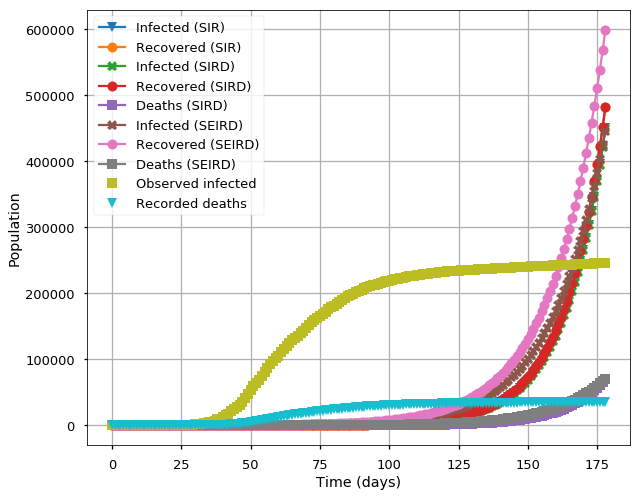

In [105]:
plt.figure(figsize=(9,7))

if has_to_run_sir:
    plt.plot(t_computed_sir, I_sir * target_population, label='Infected (SIR)', marker='v', linestyle="-", markersize=10)
    plt.plot(t_computed_sir, R_sir * target_population, label='Recovered (SIR)', marker='o', linestyle="-", markersize=10)
    
if has_to_run_sird:
    plt.plot(t_computed_sird, I_sird * target_population, label='Infected (SIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_sird, R_sird * target_population, label='Recovered (SIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_sird, D_sird * target_population, label='Deaths (SIRD)', marker='s', linestyle="-", markersize=10)
    
if has_to_run_seird:
    plt.plot(t_computed_seird, I_seird * target_population, label='Infected (SEIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, R_seird * target_population, label='Recovered (SEIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, D_seird * target_population, label='Deaths (SEIRD)', marker='s', linestyle="-", markersize=10)
    
if has_to_run_seirdq:
    plt.plot(t_computed_seirdq, I_seirdq * target_population, label='Infected (SEIRD-Q)', marker='X', linestyle="-", markersize=10)
#     plt.plot(t_computed_seirdq, R_seirdq * target_population, label='Recovered (SEIRD-Q)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_seirdq, D_seirdq * target_population, label='Deaths (SEIRD-Q)', marker='s', linestyle="-", markersize=10)

if has_to_run_seir:
    plt.plot(t_computed_seir, I_seir * target_population, label='Infected (SEIR)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_seir, R_seir * target_population, label='Recovered (SEIR)', marker='o', linestyle="-", markersize=10)
    
plt.plot(data_time, infected_individuals * target_population, label='Observed infected', marker='s', linestyle="", markersize=10)
plt.plot(data_time, dead_individuals * target_population, label='Recorded deaths', marker='v', linestyle="", markersize=10)
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Population')

plt.tight_layout()
plt.savefig("all_deterministic_calibration.png")
plt.show()

In [106]:
methods_list = list()
deaths_list = list()
if has_to_run_sird:
    methods_list.append("SIRD")
    deaths_list.append(int(D_sird.max() * target_population))
    print(f"Death estimate for today (SIRD):\t{int(D_sird.max() * target_population)}")
    
if has_to_run_seird:
    methods_list.append("SEIRD")
    deaths_list.append(int(D_seird.max() * target_population))
    print(f"Death estimate for today (SEIRD):\t{int(D_seird.max() * target_population)}")
    
if has_to_run_seirdq:
    methods_list.append("SEIRD-Q")
    deaths_list.append(int(D_seirdq.max() * target_population))
    print(f"Death estimate for today (SEIRD-Q):\t{int(D_seirdq.max() * target_population)}")

methods_list.append("Recorded")
deaths_list.append(int(dead_individuals[-1] * target_population))

death_estimates_dict = {"Method": methods_list, "Deaths estimate": deaths_list}
df_deaths_estimates = pd.DataFrame(death_estimates_dict)
print(f"Recorded deaths until today:\t{int(dead_individuals[-1] * target_population)}")

Death estimate for today (SIRD):	69932
Death estimate for today (SEIRD):	70598
Recorded deaths until today:	35112


In [107]:
# df_deaths_estimates.set_index("Model", inplace=True)
print(df_deaths_estimates.to_latex(index=False))

\begin{tabular}{lr}
\toprule
   Method &  Deaths estimate \\
\midrule
     SIRD &            69932 \\
    SEIRD &            70598 \\
 Recorded &            35112 \\
\bottomrule
\end{tabular}

